In [1]:
import os

import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [2]:
month_abbreviations = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

month_season = {
    'Jan': "winter",
    'Feb': "winter",
    'Mar': "spring",
    'Apr': "spring",
    'May': "spring",
    'Jun': "summer",
    'Jul': "summer",
    'Aug': "summer",
    'Sep': "fall",
    'Oct': "fall",
    'Nov': "fall",
    'Dec': "winter"
}

decode_season = {
    3 : "winter",
    1 : "spring",
    2 : "summer",
    0 : "fall",

}

encode_season = {
    "winter": 3,
    "spring": 1,
    "summer": 2,
    "fall": 0,
}

cdict = {
    0: 'rosybrown',
    1: 'springgreen',
    2: 'goldenrod',
    3: 'deepskyblue'
}

In [3]:
#PRECIPITION
prec = pd.read_csv("prec-Lisboa_Geofísico-hom.csv")
#drop non months columns
prec = prec.drop(["Winter","Spring","Summer","Autumn","Annual"],axis=1)

id_vars = ['year']
value_vars = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
prec_vertical = prec.melt(id_vars=id_vars, value_vars=value_vars, var_name='month', value_name='prec')

In [4]:
#TEMPERATURE
temp = pd.read_csv("temp-Lisboa_Geofísico-hom.csv")
temp['date'] = pd.to_datetime(temp['date'], format='%m/%Y')
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month.map(month_abbreviations)
temp = temp.drop(columns=['date'])
columns = ['year', 'month'] + [col for col in temp.columns if col not in ['year', 'month']]
temp = temp.reindex(columns=columns)

In [5]:
#PRESSURE
press = pd.read_csv("press-Lisboa_Geofísico-hom.csv")

press['date'] = pd.to_datetime(press['date'], format='%m/%Y')
press['year'] = press['date'].dt.year
press['month'] = press['date'].dt.month.map(month_abbreviations)
press = press.drop(columns=['date'])

columns = ['year', 'month'] + [col for col in press.columns if col not in ['year', 'month']]
press = press.reindex(columns=columns)

In [6]:
#MERGE DATA
m1 = pd.merge(prec_vertical,temp,on=["year","month"])
df_merged = pd.merge(m1, press, on=['year', 'month'])

df_merged["season"] = df_merged["month"].map(month_season)
df_merged["temp_deviation"] = (df_merged["tmax"] - df_merged["tmin"])**2
df_merged.drop(["tmin","tmax"], inplace=True,axis=1)
df_merged = df_merged.join(pd.get_dummies(df_merged.season)).drop(["season"],axis=1)
data = df_merged.drop(["year","month"],axis=1).dropna()

In [7]:
data

,prec,tmed,press,temp_deviation,fall,spring,summer,winter
0,0.8,9.62,1015.88,55.3536,0,0,0,1
1,116.5,9.50,1005.82,20.7936,0,0,0,1
2,60.0,9.41,1013.68,25.1001,0,0,0,1
3,20.6,11.67,1013.64,27.0400,0,0,0,1
4,89.7,9.42,1008.09,30.8025,0,0,0,1
...,...,...,...,...,...,...,...,...
1703,7.8,13.66,1012.26,43.8244,1,0,0,0
1704,193.6,15.47,1005.58,44.0896,1,0,0,0
1705,132.5,15.20,1004.79,31.1364,1,0,0,0
1706,26.0,14.16,1010.01,47.8864,1,0,0,0


array([[<AxesSubplot: title={'center': 'prec'}>,
        <AxesSubplot: title={'center': 'tmed'}>,
        <AxesSubplot: title={'center': 'press'}>],
       [<AxesSubplot: title={'center': 'temp_deviation'}>,
        <AxesSubplot: title={'center': 'fall'}>,
        <AxesSubplot: title={'center': 'spring'}>],
       [<AxesSubplot: title={'center': 'summer'}>,
        <AxesSubplot: title={'center': 'winter'}>, <AxesSubplot: >]],
      dtype=object)

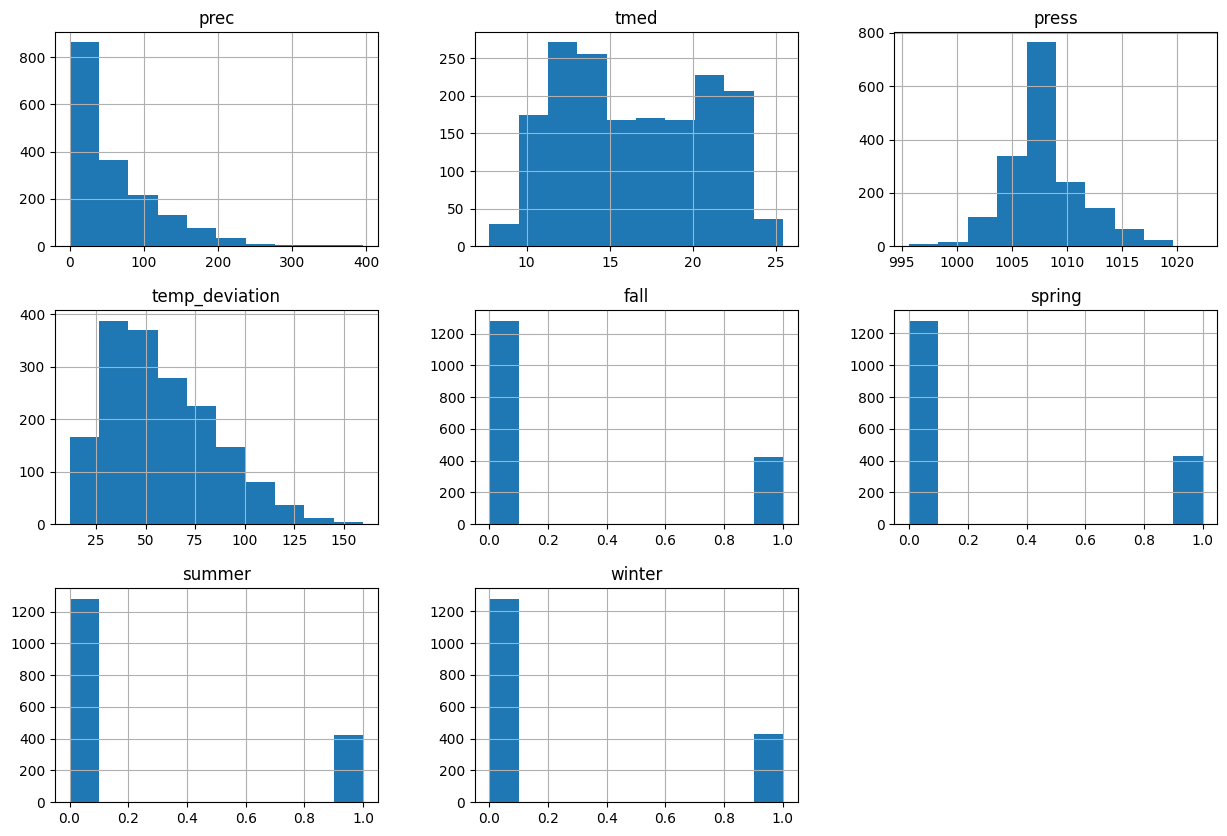

In [8]:
data.hist(figsize=(15, 10))

<AxesSubplot: >

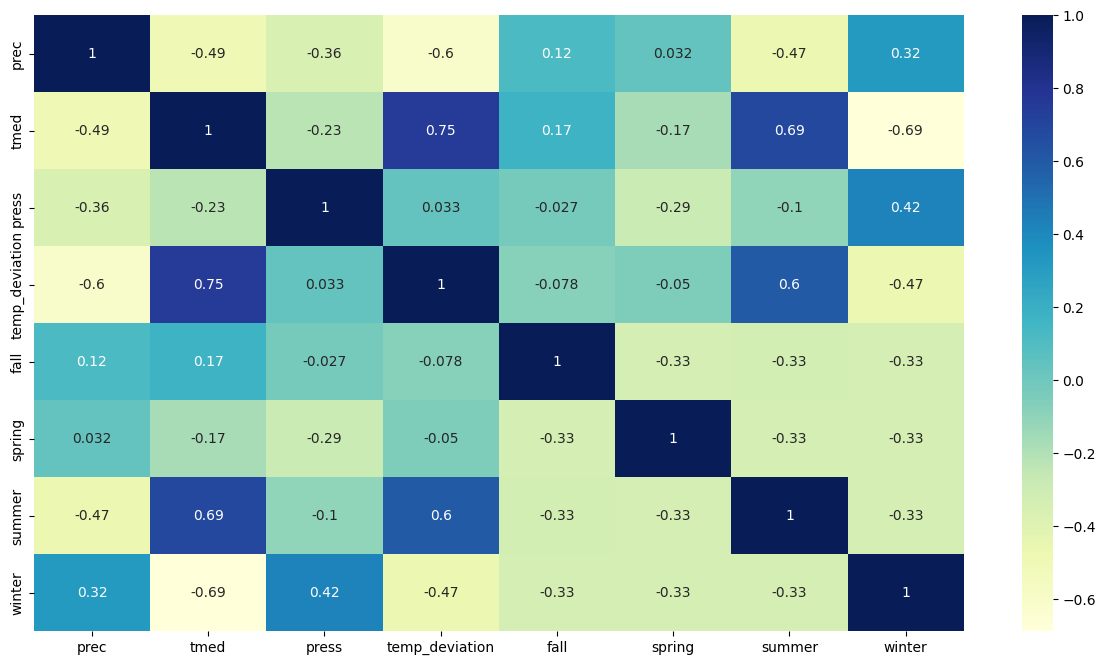

In [9]:
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(),annot=True,cmap='YlGnBu')

In [10]:
X_data = data.drop(["fall","spring","summer","winter"],axis=1)
scaler = preprocessing.StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data)
y_data = data[["fall","spring","summer","winter"]]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data, test_size=0.2)

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input((X_train.shape[1],)))                             #input  layer                                          
model.add(tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU()))       #hidden layers 
model.add(tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU()))       #hidden layers 
model.add(tf.keras.layers.Dense(4,activation='sigmoid'))


model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 1,348
Trainable params: 1,348
Non-trainable params: 0
_________________________________________________________________


In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
callbacks = [early_stop]

In [13]:
hist = model.fit(x=X_train,y=y_train,validation_split=0.2,batch_size=64,epochs=1000,callbacks=callbacks,verbose=1)

Epoch 1/1000
18/18 [==============================] - 1s 7ms/step - loss: 0.6673 - accuracy: 0.3599 - val_loss: 0.6195 - val_accuracy: 0.5584
Epoch 2/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.5834 - accuracy: 0.5916 - val_loss: 0.5559 - val_accuracy: 0.5766
Epoch 3/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.5206 - accuracy: 0.6053 - val_loss: 0.5063 - val_accuracy: 0.5620
Epoch 4/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4705 - accuracy: 0.6190 - val_loss: 0.4681 - val_accuracy: 0.5693
Epoch 5/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4304 - accuracy: 0.6328 - val_loss: 0.4390 - val_accuracy: 0.5584
Epoch 6/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.3990 - accuracy: 0.6429 - val_loss: 0.4145 - val_accuracy: 0.5839
Epoch 7/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.3757 - accuracy: 0.6502 - val_loss: 0.3972 - val_accuracy: 0.6022
Epoch 

In [14]:
model.evaluate(X_test,y_test)

11/11 [==============================] - 0s 1ms/step - loss: 0.1934 - accuracy: 0.8596


[0.1934415102005005, 0.859649121761322]

In [15]:
model.save("season_predictor")

INFO:tensorflow:Assets written to: season_predictor\assets


INFO:tensorflow:Assets written to: season_predictor\assets


In [16]:
a = model.predict(X_test).argmax(axis=1)
pred = np.vectorize(decode_season.get)(a)

11/11 [==============================] - 0s 600us/step


In [17]:
true = y_test.idxmax(axis=1).to_numpy().astype("<U6")

In [18]:
diff = np.compare_chararrays(true, pred, "!=", True)

In [19]:
np.count_nonzero(diff, axis=None)

48

In [20]:
truth = true[diff]
prediction = pred[diff]
for t,p in zip(truth,prediction):
    print("true:{truth}, pred:{predict}".format(truth=t,predict=p))

true:spring, pred:winter
true:winter, pred:spring
true:spring, pred:fall
true:spring, pred:fall
true:fall, pred:summer
true:summer, pred:fall
true:winter, pred:fall
true:fall, pred:summer
true:fall, pred:summer
true:winter, pred:fall
true:fall, pred:summer
true:winter, pred:spring
true:fall, pred:spring
true:fall, pred:winter
true:fall, pred:spring
true:spring, pred:summer
true:fall, pred:summer
true:spring, pred:summer
true:summer, pred:spring
true:fall, pred:summer
true:fall, pred:spring
true:summer, pred:fall
true:spring, pred:summer
true:fall, pred:summer
true:fall, pred:summer
true:fall, pred:summer
true:fall, pred:spring
true:fall, pred:spring
true:summer, pred:fall
true:fall, pred:spring
true:winter, pred:spring
true:spring, pred:winter
true:fall, pred:winter
true:fall, pred:spring
true:spring, pred:winter
true:fall, pred:summer
true:summer, pred:fall
true:spring, pred:fall
true:summer, pred:fall
true:spring, pred:winter
true:fall, pred:summer
true:fall, pred:summer
true:summer,

In [21]:
stack = np.stack((true, diff), axis=-1)
winter_hit = np.count_nonzero(((stack[:,0] == 'winter') & (stack[:,1] == 'False')), axis=0)/np.count_nonzero((stack[:,0] == 'winter'),axis=0)
summer_hit = np.count_nonzero(((stack[:,0] == 'summer') & (stack[:,1] == 'False')), axis=0)/np.count_nonzero((stack[:,0] == 'winter'),axis=0)
fall_hit = np.count_nonzero(((stack[:,0] == 'fall') & (stack[:,1] == 'False')), axis=0)/np.count_nonzero((stack[:,0] == 'winter'),axis=0)
spring_hit = np.count_nonzero(((stack[:,0] == 'spring') & (stack[:,1] == 'False')), axis=0)/np.count_nonzero((stack[:,0] == 'winter'),axis=0)

In [22]:
print("Winter correctly classified:{winter_hit:.2f}%".format(winter_hit=winter_hit*100))
print("Summer correctly classified:{summer_hit:.2f}%".format(summer_hit=summer_hit*100))
print("Fall correctly classified:{fall_hit:.2f}%".format(fall_hit=fall_hit*100))
print("Spring correctly classified:{spring_hit:.2f}%".format(spring_hit=spring_hit*100))

Winter correctly classified:94.79%
Summer correctly classified:86.46%
Fall correctly classified:59.38%
Spring correctly classified:65.62%
